In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
import matplotlib.image as mpimg
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Get images
nbImages = 100
y = []
i = 0
with open("coloredImages.txt") as f:    
    for filename in tqdm(f.readlines()[:nbImages]):
        filename = filename.rstrip()
        filename += ".jpg"
        img = cv2.resize(
            mpimg.imread('data/images/'+filename),
            dsize=(128, 128),
            interpolation=cv2.INTER_CUBIC
        )
        y.append(img)
y = np.array(y)
print(y.shape)

100%|██████████| 16/16 [00:00<00:00, 411.35it/s]


(16, 128, 128, 3)


In [3]:
# Transform img to Grayscale
X = []
for img in tqdm(y):
    X.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
X = np.array(X)
print(X.shape)

100%|██████████| 16/16 [00:00<00:00, 8127.51it/s]


(16, 128, 128)


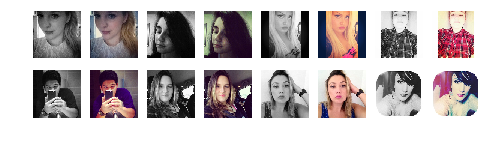

In [4]:
columns = 8
rows = 2
fig=plt.figure(figsize=(columns, rows))
for i in range(1, columns*rows +1,2):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X[i-1], cmap='gray')
    plt.axis('off')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(y[i-1])
    plt.axis('off')
plt.show()

In [5]:
# Keras
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback

X_reshaped = X.reshape(X.shape[0],128,128,1)

model = Sequential()
model.add(Conv2D(3, kernel_size=5, padding="same", activation = 'relu', input_shape=X_reshaped.shape[1:]))
model.add(Conv2D(64, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192, kernel_size=3, padding="same", activation = 'relu'))
#model.add(Flatten())
model.add(Reshape((128,128,3)))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 3)       78        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_

In [6]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy']
)

In [19]:
from IPython.core.display import HTML
display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

history = model.fit(
    X_reshaped,
    y,
    epochs=200, 
    batch_size=1, 
    verbose=0, 
    callbacks=[
        TQDMNotebookCallback()
    ]
)


In [20]:
history.history.keys()

dict_keys(['loss', 'acc'])

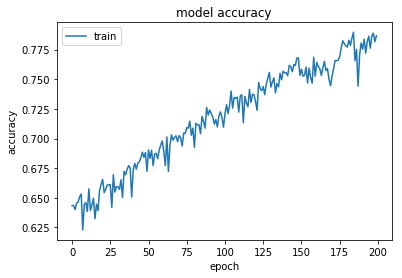

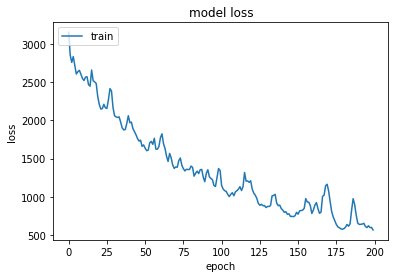

In [21]:
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

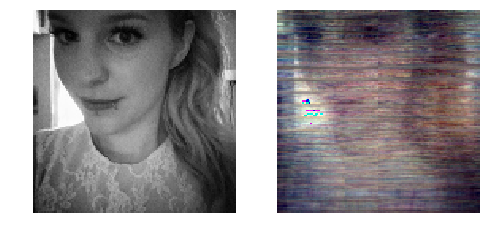

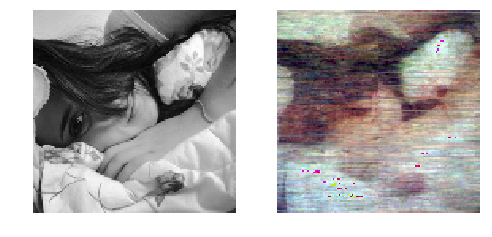

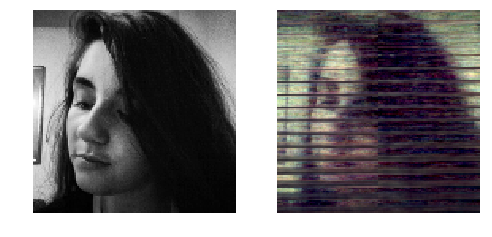

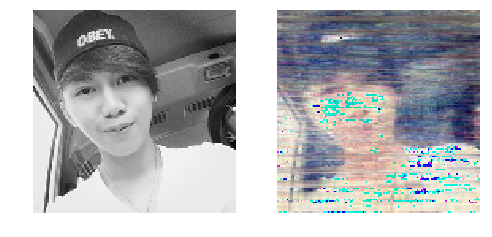

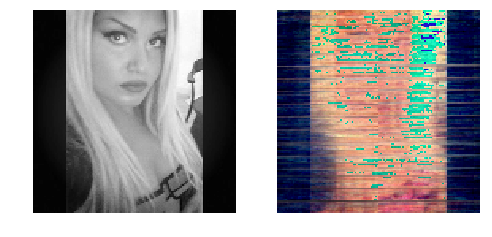

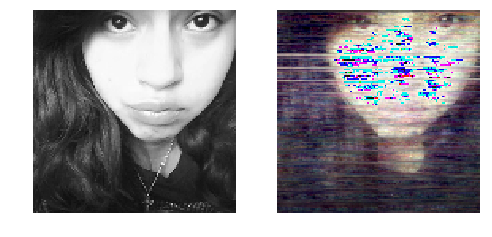

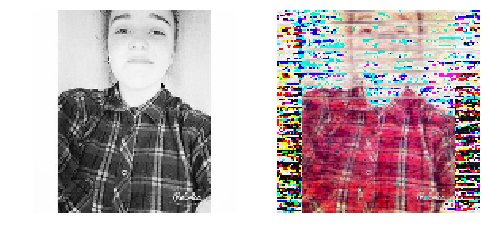

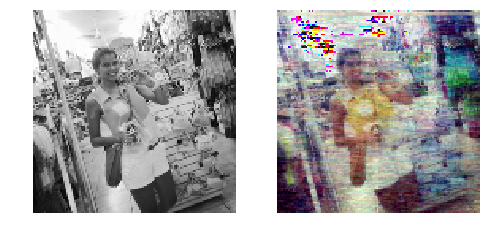

In [22]:

for id in range(8):
    fig = plt.figure(figsize=(8, 4))
    fig.add_subplot(1, 2, 1)
    plt.imshow(X[id], cmap='gray')
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(np.uint8(model.predict(X_reshaped[id:id+1])[0]))
    plt.axis('off')
    plt.show()

In [23]:
model.save('coloRayzor.h5')